In [14]:
import kfp
import kfp.components as comp
import requests
import kfp.dsl as dsl
# import pandas as pd

In [163]:
import requests
from io import StringIO
import pandas as pd

url = "https://query1.finance.yahoo.com/v7/finance/download/SAIL.NS?period1=1658311525&period2=1689847525&interval=1d&events=history&includeAdjustedClose=true"
my_file = requests.get(url)

data = StringIO(my_file.text)
print(my_file.text)
test = pd.read_csv(data)
# test.head()

Forbidden


In [165]:
import wget
test = wget.download(url)

In [166]:
test = pd.read_csv(test)
test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-07-20,74.300003,76.150002,74.150002,74.949997,71.878105,61219545
1,2022-07-21,75.000000,76.000000,74.400002,75.599998,72.501465,31038381
2,2022-07-22,76.050003,76.300003,74.699997,75.300003,72.213776,21258642
3,2022-07-25,75.250000,76.150002,74.800003,76.000000,72.885078,19924422
4,2022-07-26,76.250000,76.599998,74.500000,74.949997,71.878105,24458733


In [238]:

def prepare_data():
    import pandas as pd
    import numpy
    import wget
    # data = pd.read_csv("data/SAIL.NS.csv")
    url = "https://query1.finance.yahoo.com/v7/finance/download/SAIL.NS?period1=820454400&period2=1689811200&interval=1d&events=history&includeAdjustedClose=true"
    test = wget.download(url)
    data = pd.read_csv(test)
    data['year'] = pd.to_datetime(data['Date']).dt.year
    data['month'] = pd.to_datetime(data['Date']).dt.month
    data['day'] = pd.to_datetime(data['Date']).dt.day
    data = data.drop(['Date'], axis = 1)

    for c in data.columns:
        data[c].fillna(data[c].mean(), inplace=True)
    data.to_csv(f'data/final_data.csv', index = False)

In [239]:
# check = prepare_data()

# check.head()

In [240]:
def train_test_split():
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import MinMaxScaler
    data = pd.read_csv("data/final_data.csv")
    mms = MinMaxScaler(feature_range=(0,1))
    scaled_data = mms.fit_transform(data['Close'].values.reshape(-1,1))

    prediction_days = 60
    x_train = []
    y_train = []

    for i in range(prediction_days, len(scaled_data)):
        x_train.append(scaled_data[i - prediction_days: i, 0])
        y_train.append(scaled_data[i, 0])
        
    xdata, ydata = np.array(x_train), np.array(y_train)

    train_size = 0.66
    val_size = 0.2
    test_size = 0.2

    xtrain, ytrain = xdata[0:int(xdata.shape[0]*train_size)], ydata[0:int(ydata.shape[0]*train_size)]
    xval, yval = xdata[xtrain.shape[0]+1:int(xtrain.shape[0] + (xdata.shape[0]-xtrain.shape[0])*0.5)], ydata[ytrain.shape[0]+1:int(ytrain.shape[0] + (ydata.shape[0]-ytrain.shape[0])*0.5)]
    xtest, ytest = xdata[int(xtrain.shape[0]+xval.shape[0]+1):], ydata[int(ytrain.shape[0]+yval.shape[0]+1):]
    
    np.save(f'data/xtrain.npy',xtrain)
    np.save(f'data/xval.npy', xval)
    np.save(f'data/xtest.npy', xtest)
    np.save(f'data/ytrain.npy',ytrain)
    np.save(f'data/yval.npy', yval)
    np.save(f'data/ytest.npy', ytest)

In [241]:
# train_test_split()

In [242]:
def training_rf_regressor():
    import numpy as np
    import pandas as pd
    import pickle
    from sklearn.ensemble import RandomForestRegressor
    
    xtrain = np.load(f'data/xtrain.npy', allow_pickle=True)
    ytrain = np.load(f'data/ytrain.npy', allow_pickle=True)
    rfr_final = RandomForestRegressor(n_estimators=10, max_depth=10)
    rfr_final.fit(xtrain, ytrain)
    rfr_optuna = RandomForestRegressor(n_estimators=11, max_depth=57)
    rfr_optuna.fit(xtrain, ytrain)
    
    with open(f'data/rfr_final.pkl', 'wb') as f:
        pickle.dump(rfr_final, f)
        
    with open(f'data/rfr_optuna.pkl', 'wb') as f:
        pickle.dump(rfr_optuna, f)

In [243]:
# training_rf_regressor()

In [244]:
def prep_test_data():
    import numpy as np
    import pandas as pd
    import pickle
    import matplotlib.pyplot as plt
    
    with open(f'data/rfr_optuna.pkl', 'rb') as f:
        rfr_optuna = pickle.load(f)
    xtest = np.load(f'data/xtest.npy', allow_pickle=True)
    ypred = rfr_optuna.predict(xtest)
    np.save(f'data/ypred.npy', ypred)
    
    ytest = np.load(f'data/ytest.npy', allow_pickle=True)
    plt.figure(figsize=(25, 10))
    plt.plot(ytest, c = 'blue')
    plt.plot(ypred, c = 'red')
    plt.show()
    

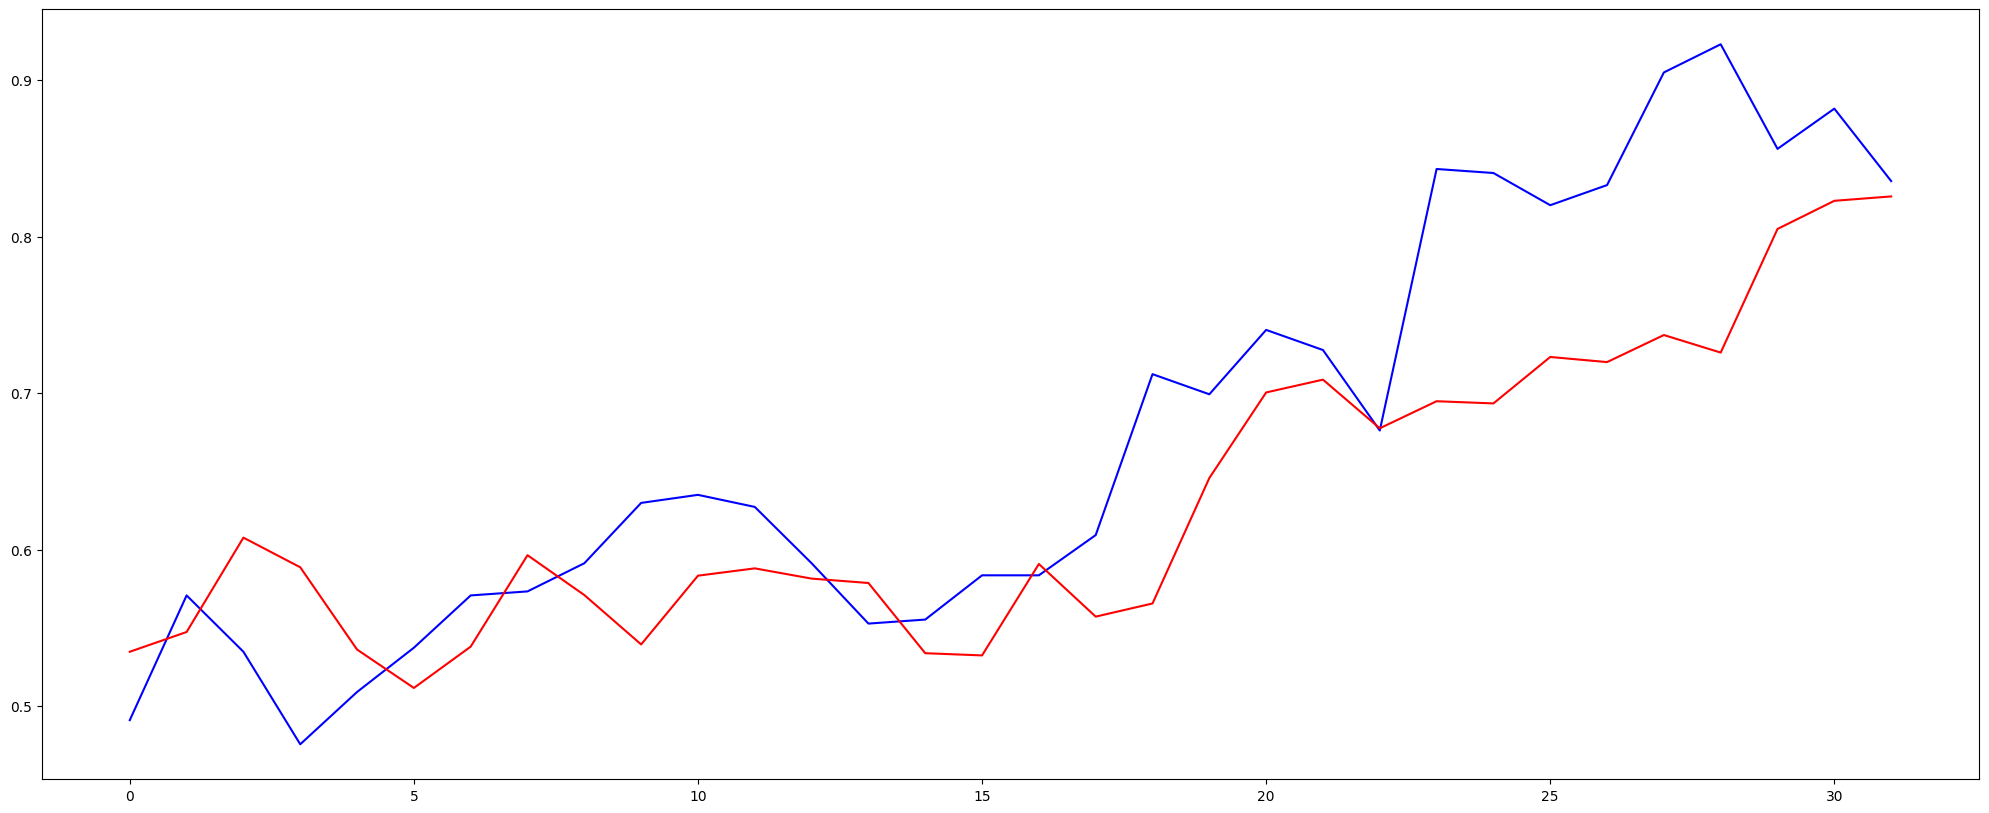

In [231]:
# prep_test_data()

In [245]:
create_step_prep_data = kfp.components.create_component_from_func(
    func = prepare_data,
    base_image='python:3.7',
    packages_to_install=['pandas', 'numpy', 'wget', 'matplotlib']
)
    
create_setp_train_test_split = kfp.components.create_component_from_func(
    func = train_test_split,
    base_image='python:3.7',
    packages_to_install=['pandas', 'numpy', 'scikit-learn', 'matplotlib']
)

create_step_training = kfp.components.create_component_from_func(
    func = training_rf_regressor,
    base_image='python:3.7',
    packages_to_install=['pandas', 'numpy', 'scikit-learn', 'matplotlib']
)

create_step_predict = kfp.components.create_component_from_func(
    func=prep_test_data,
    base_image='python:3.7',
    packages_to_install=['pandas', 'numpy', 'scikit-learn', 'matplotlib']
)

In [246]:
@dsl.pipeline(
    name="sail prediction demo pipeline",
    description="testing sample"
)
def sail_prediction_pipeline(data_path: str):
    vop = dsl.VolumeOp(
        name = "t-vol",
        resource_name = "t-vol",
        size = "1Gi",
        modes=dsl.VOLUME_MODE_RWO
    )
    
    prepare_data_task = create_step_prep_data().add_pvolumes({data_path: vop.volume})
    train_test_split = create_setp_train_test_split().add_pvolumes({data_path: vop.volume}).after(prepare_data_task)
    regressor_training = create_step_training().add_pvolumes({data_path: vop.volume}).after(train_test_split)
    predict_task = create_step_predict().add_pvolumes({data_path: vop.volume}).after(regressor_training)
    
    prepare_data_task.execution_options.caching_strategy.max_cache_staleness = "POD"
    train_test_split.execution_options.caching_strategy.max_cache_staleness = "POD"
    regressor_training.execution_options.caching_strategy.max_cache_staleness = "POD"
    predict_task.execution_options.caching_strategy.max_cache_staleness = "POD"

In [247]:
kfp.compiler.Compiler().compile(
    pipeline_func = sail_prediction_pipeline,
    package_path = 'sail_prediction_pipeline.yaml'
)

In [9]:
client = kfp.Client()

In [248]:
DATA_PATH = '/data'

import datetime
print(datetime.datetime.now().date())

pipeline_func = sail_prediction_pipeline
experiment_name = 'sail_prediction_exp' + "_" + str(datetime.datetime.now().date())
run_name = pipeline_func.__name__ + ' run'
namespace = "kubeflow"

arguments = {"data_path": DATA_PATH}

kfp.compiler.Compiler().compile(
    pipeline_func,
    '{}.zip'.format(experiment_name),
)

run_result = client.create_run_from_pipeline_func(
    pipeline_func,
    experiment_name = experiment_name,
    run_name = run_name,
    arguments = arguments
)

2023-07-20
